In [76]:
# import lib
import numpy      as np
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from   plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# data set 
import sklearn.datasets as datasets

init_notebook_mode(connected=True); np.random.seed(6789); tf.set_random_seed(67890); plt.style.use('seaborn')

In [88]:
# create functions and start session
try: 
    if sess._closed: sess = tf.InteractiveSession()
except:
    sess = tf.InteractiveSession()
def np_pca_svd(X):
    U,s,VT = np.linalg.svd(X,full_matrices=True)
    S      = np.diag(s)
    return U,S,VT.T
    
def tf_pca_svd(X): 
    s,U,V  = tf.linalg.svd(X,full_matrices=True)
    S      = tf.diag(s)
    return U.eval(),S.eval(),V.eval()

def normalize_sign(A,B):
    """
    utility function for resolving the sign ambiguity in SVD
    http://stats.stackexchange.com/q/34396/115202
    """
    signs = np.sign(A) * np.sign(B)
    return A, B * signs    

number_of_data = 4000
skew_matrix    = np.array([[2,0.2],[1.1,0]])

(4000, 4000)
(2, 2)
(2, 2)


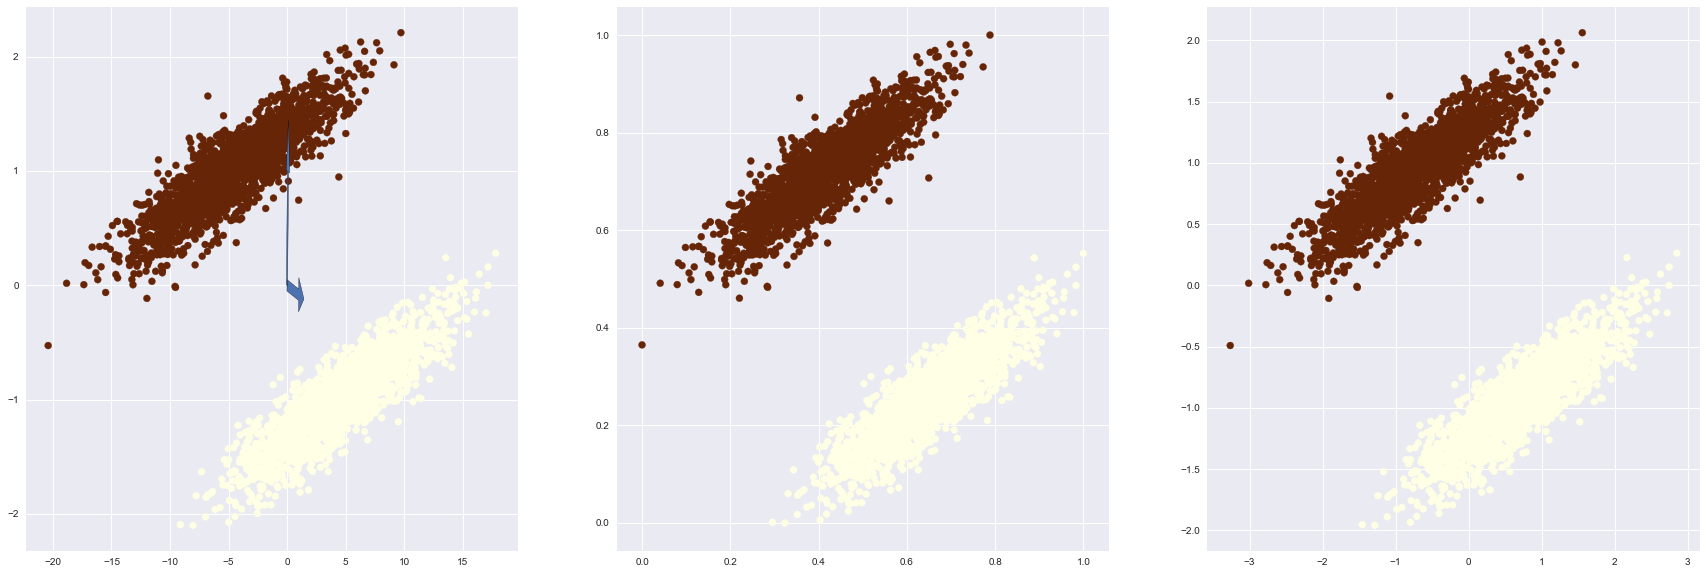

In [100]:
# create some simple dataset blobs and skew it (center it as well)
data,label = datasets.make_blobs(n_samples=number_of_data,centers=2,random_state=23,cluster_std =1.9,center_box =(-20,20))
data       = data @ skew_matrix
data       = data - data.mean(0,keepdims=True)

# 1. preprocess the data
normalized_data = (data-data.min(0,keepdims=True)) /(data.max(0,keepdims=True)-data.min(0,keepdims=True))
stadnardiz_data = (data-data.mean(0,keepdims=True))/ data.std(0,keepdims=True)

# 2. get the pc for each
og_U,og_S,og_V = tf_pca_svd(data)
print(og_U.shape)
print(og_S.shape)
print(og_V.shape)


plt.figure(figsize=(30,10))
plt.subplot(131); plt.scatter(data[:,0],data[:,1],c=label,cmap='YlOrBr')
plt.arrow(0,0,*og_V[:,0],width=0.1)
plt.arrow(0,0,*og_V[:,1],width=0.1)


plt.subplot(132); plt.scatter(normalized_data[:,0],normalized_data[:,1],c=label,cmap='YlOrBr')
plt.subplot(133); plt.scatter(stadnardiz_data[:,0],stadnardiz_data[:,1],c=label,cmap='YlOrBr')
plt.show()

# Reference 
1. PCA?, R. (2018). Relationship between SVD and PCA. How to use SVD to perform PCA?. Cross Validated. Retrieved 15 November 2018, from https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
2. tf.linalg.svd | TensorFlow. (2018). TensorFlow. Retrieved 15 November 2018, from https://www.tensorflow.org/api_docs/python/tf/linalg/svd
3. Line and Scatter Plots. (2018). Plot.ly. Retrieved 15 November 2018, from https://plot.ly/matplotlib/line-and-scatter/
4. exception)?, H. (2018). How to check if a Tensorflow Session is still open (without catching an exception)?. Stack Overflow. Retrieved 15 November 2018, from https://stackoverflow.com/questions/42974627/how-to-check-if-a-tensorflow-session-is-still-open-without-catching-an-exceptio
5. sklearn.datasets.make_blobs — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 15 November 2018, from https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
6. Styling Markers. (2018). Plot.ly. Retrieved 15 November 2018, from https://plot.ly/python/marker-style/
7. Subplots. (2018). Plot.ly. Retrieved 15 November 2018, from https://plot.ly/python/subplots/
8. matplotlib, S. (2018). Seaborn configuration hides default matplotlib. Stack Overflow. Retrieved 15 November 2018, from https://stackoverflow.com/questions/33099348/seaborn-configuration-hides-default-matplotlib
9. color example code: colormaps_reference.py — Matplotlib 2.0.2 documentation. (2018). Matplotlib.org. Retrieved 15 November 2018, from https://matplotlib.org/examples/color/colormaps_reference.html
10. 